<a href="https://colab.research.google.com/github/dareoyeleke/python_scripting/blob/main/Pandas3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧮 Pandas 3: Data Cleaning, Transformation, and Analytical Preparation

This notebook focuses on **practical data cleaning and transformation workflows using Pandas**, with an emphasis on preparing datasets for analysis and visualization.

Building on foundational Pandas concepts, this notebook demonstrates how to:
- Manipulate and validate indexes and columns for consistency
- Handle missing data using `.fillna()` and `.dropna()` based on analytical intent
- Identify and remove duplicate records to maintain data integrity
- Use `.copy()` safely to avoid chained assignment issues
- Reshape data with `pivot_table()` to support aggregated analysis
- Prepare cleaned datasets for plotting and exploratory analysis

The goal of this notebook is not just to apply Pandas methods, but to **model real-world data preparation decisions** while analyzing data before visualization or downstream analysis.

This workflow reflects common preprocessing tasks encountered in analytics, reporting, and business intelligence pipelines.


## 🛠️ Skills Demonstrated

**Data Cleaning & Preparation**
- Handling missing values with `.fillna()` and `.dropna()`
- Identifying and removing duplicate records using `.drop_duplicates()`
- Safely copying DataFrames with `.copy()` to avoid chained assignment issues

**Data Manipulation & Structuring**
- Index and column manipulation for consistency and readability
- Reshaping datasets with `pivot_table()` for aggregated analysis
- Applying transformations to prepare data for downstream use

**Analytical Readiness**
- Preparing cleaned datasets for visualization and exploratory analysis
- Structuring data to support trend analysis and summary reporting
- Applying real-world preprocessing decisions aligned with analytics workflows

**Tools & Libraries**
- Python
- Pandas
- Matplotlib (for post-cleaning visualization preparation)


In [ ]:
! pip install datasets
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt

# Load data for use
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Little bit of data clean up
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])

# https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf. One stop shop cheat sheet as a reference for common Pandas information

In [12]:
'''
  I'll be showcasing merging DataFrames using a previously created pivot table showing the Number of Job Postings per month for every job position
Once I get that done in this cell, I will be importing the DataFrame to be merged and then the real fun begins
'''
df_usa_jobs = df[df['job_country'] == "United States"]

df_usa_jobs['job_month_posted'] = df_usa_jobs['job_posted_date'].dt.strftime('%B')
# using the strftime function, we can print out the month from the job_posted_date from the df_usa_jobs DataFrame in a new column as the month names
df_usa_jobs # Here we can check to confirm we have a column to prove the months were printed

df_usa_month_pivot = df_usa_jobs.pivot_table(index='job_month_posted', columns='job_title_short', aggfunc='size')

'''
  This gives the number of job postings per month for every postion, taking NaN values also into consideration using 'size' as opposed to 'count' for the .aggfunc,
however it prints out the months in alphabetical order as oppossed to chronologically, sorting can potentially change it to ascending or descending, but not chronological
'''
df_usa_month_pivot.reset_index(inplace=True) # We start by creating an index of numbers to attach the months to.

df_usa_month_pivot['month_no'] = pd.to_datetime(df_usa_month_pivot['job_month_posted'], format='%B').dt.month  # creating a column aligning the month names with month numbers

df_usa_month_pivot.sort_values('month_no', inplace=True) # sorting the month numbers, and thereby names in chronological order

df_usa_month_pivot.set_index('job_month_posted', inplace=True) # and then setting the month numbers, month_no as the index.

df_usa_month_pivot.drop(columns='month_no', inplace=True)
# df_usa_month_pivot.drop(columns=['level_0', 'index', inplace=True]) used to drop recurring columns specified in list, columns

df_usa_month_pivot # now we have our final table cleaned up for plotting

data_jobs = ['Data Analyst', 'Data Engineer', 'Data Scientist'] # To narrow down to only the Data jobs I'm concerned about

Data_job_month_demand = df_usa_month_pivot[data_jobs]

Data_job_month_demand # However in the next cell I will be working with all the jobs in the table, not just Data jobs, so I will be using the DataFrame before filtering for Data Jobs, i.e df_usa_month_pivot


df_usa_month_pivot # This is the DataFrame I will be merging the Software DataFrame with, how


/tmp/ipython-input-603601265.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_usa_jobs['job_month_posted'] = df_usa_jobs['job_posted_date'].dt.strftime('%B')


job_title_short,Business Analyst,Cloud Engineer,Data Analyst,Data Engineer,Data Scientist,Machine Learning Engineer,Senior Data Analyst,Senior Data Engineer,Senior Data Scientist,Software Engineer
job_month_posted,,,,,,,,,,
January,527,36,8494,2655,6915,60,1544,773,1552,114
February,447,24,6124,3060,4956,56,1258,878,1127,90
March,438,19,6218,3183,4779,59,1114,829,1150,115
April,565,40,6049,2801,4867,51,1025,781,991,112
May,279,20,4993,2976,4377,49,839,746,914,90
June,446,32,5683,2893,4645,48,1009,812,1033,93
July,581,39,5201,2570,4876,65,883,747,1095,153
August,903,39,6634,3269,6318,68,1186,903,1515,194
September,897,50,4639,3224,4568,113,805,775,1014,228


In [13]:
software_jobs = pd.read_csv("https://lukeb.co/software_csv") # Importing and creating a DataFrame for software jobs from the internet

software_jobs = software_jobs.set_index('job_posted_month')  # Here we set the index to The month column

software_jobs_DF = software_jobs.copy() # Create a copy so the original remains intact

software_jobs_DF

software_jobs_DF.rename(columns={'Front-End Developer' : 'Front_End_Dev', 'Back-End Developer' : 'Back_End_Dev', 'Full-Stack Developer' : 'Full_Stack_Dev', 'UI/UX Designer' : 'UI/UX_Des' })
# rename the columns to make them easier to call

# However to make merging easier, I'll make sure the identical columns have identical column names
df_usa_month_pivot.index.name = 'job_posted_month'
df_usa_month_pivot.index.name
# since it is the index, I have to use the .index.name as opposed to .rename(column) to change the name, alternatively I could use left_on, and right_on to merge columns with different names

# Now to merge both DataFrames

df_US_merged_jobs = df_usa_month_pivot.merge(software_jobs_DF, on='job_posted_month')

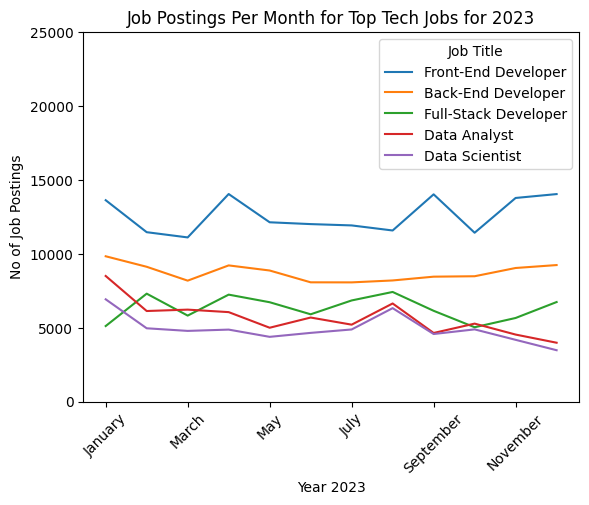

In [14]:
'''
  I will be creating another visual showing the top 5 Jobs from the merged Table to see the Trends in Jobs over the course of the year.
To get the top 5 jobs, we'll be doing a sum of the job counts to see the top 5 first, and then plotting those 5 jobs
'''

top_5_jobs = (df_US_merged_jobs
              .sum() # sum of all job positions
              .sort_values(ascending=False) # sort the sums from ascending to descending
              .head() # gives the top 5 values
              .index) # prints out the index values

top_5_jobs # The names of the top 5 jobs we need for the visual

df_US_merged_jobs[top_5_jobs].plot() # plots a line chart by default
plt.title('Job Postings Per Month for Top Tech Jobs for 2023')
plt.ylabel('No of Job Postings')
plt.xlabel('Year 2023')
plt.xticks(rotation= 45)
plt.legend(title='Job Title')
plt.ylim(0, 25000)
plt.show()

# We now have a line chart showing the Trends in Job Postings for year 2023


In [15]:
'''
  Next using Concatenate method, I will be creating a DataFrame, to represent the Data for the first yearly quater, i.e Jan - March.
Concatenate, as opposed to Merge( adding more columns to the DataFrames), Bascially adds more rows. I.e Merge is sideways increasing,
concatenate is lengthwise increasing. To do that, I'll be creating some DataFrames by segmenting data from DataFrame(df) by the month and then concatenating them.
'''
df['job_posted_month'] = df['job_posted_date'].dt.strftime('%b') # first i create a new column pulling out shortened month names from the date/time column

months = df['job_posted_month'].unique() # and then put those values in a list and store them in an object

months

dict_months = {month : df[df['job_posted_month'] == month] for month in months }
'''
  I use dict comprehension for every value in the object month printed out with the key as the month, and the value as a DataFrame printed out,
filtering the DataFrame(df) for the month called through every iteration of the loop. i.e if the month is Jan, filter df where the
'job_posted_month' is also Jan and store the key value as Jan, repeat this for every month value in months(holds all the month values)
'''

dict_months['Jan'] # verifying that it works by checking for the month of Jan

# Now to finally concat the data
df_Q1 = pd.concat([dict_months['Jan'], dict_months['Feb'], dict_months['Mar']], ignore_index=True) # Here we have the Job Postings for Q1 in order from Jan to March
df_Q1

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills,job_posted_month
0,Data Analyst,Data Analyst,"Guadalajara, Jalisco, Mexico",via BeBee México,Full-time,False,Mexico,2023-01-14 13:18:07,False,False,Mexico,None,NaN,NaN,Hewlett Packard Enterprise,"['r', 'python', 'sql', 'nosql', 'power bi', 't...","{'analyst_tools': ['power bi', 'tableau'], 'pr...",Jan
1,Data Scientist,Data Scientist,"Zaventem, Belgium",via BeBee Belgique,Full-time,False,Belgium,2023-01-31 13:53:38,False,False,Belgium,None,NaN,NaN,Devoteam,"['r', 'python', 'sql', 'pandas', 'numpy', 'sci...","{'libraries': ['pandas', 'numpy', 'scikit-lear...",Jan
2,Data Engineer,Data Engineer,"Fort Worth, TX",via LinkedIn,Full-time,False,"Texas, United States",2023-01-25 13:24:01,False,False,United States,None,NaN,NaN,Programmers.io,"['sql', 'python']","{'programming': ['sql', 'python']}",Jan
3,Data Engineer,Data Engineer,"San Mateo, CA",via LinkedIn,Full-time,False,"California, United States",2023-01-28 13:07:30,False,True,United States,None,NaN,NaN,Verkada,"['sql', 'python', 'aws', 'looker']","{'analyst_tools': ['looker'], 'cloud': ['aws']...",Jan
4,Data Scientist,Data Scientist,"São Paulo, State of São Paulo, Brazil",via BeBee,Full-time,False,Brazil,2023-01-03 23:02:27,False,False,Brazil,None,NaN,NaN,Mars,"['python', 'sql', 'azure']","{'cloud': ['azure'], 'programming': ['python',...",Jan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220479,Software Engineer,DevOps Engineer,Singapura,melalui Trabajo.org,Pekerjaan tetap,False,Singapore,2023-03-13 06:16:16,False,False,Singapore,None,NaN,NaN,CAREERSTAR INTERNATIONAL PTE. LTD.,"['bash', 'python', 'perl', 'linux', 'unix', 'k...","{'os': ['linux', 'unix'], 'other': ['kubernete...",Mar
220480,Data Analyst,CRM Data Analyst,"Bad Rodach, Jerman",melalui BeBee Deutschland,Pekerjaan tetap,False,Germany,2023-03-12 06:18:18,False,False,Germany,None,NaN,NaN,HABA FAMILYGROUP,"['sas', 'sas', 'sql', 'excel']","{'analyst_tools': ['sas', 'excel'], 'programmi...",Mar
220481,Business Analyst,Commercial Analyst - Start Now,Malaysia,melalui Ricebowl,Pekerjaan tetap,False,Malaysia,2023-03-12 06:32:36,False,False,Malaysia,None,NaN,NaN,Lendlease Corporation,"['powerpoint', 'excel']","{'analyst_tools': ['powerpoint', 'excel']}",Mar
220482,Data Engineer,"Principal Associate, Data Engineer (Remote-Eli...","Newark, New Jersey, Amerika Serikat",melalui Recruit.net,Pekerjaan tetap,False,Sudan,2023-03-12 06:32:15,False,False,Sudan,None,NaN,NaN,Capital One,"['python', 'go', 'nosql', 'sql', 'mongo', 'she...","{'cloud': ['aws', 'snowflake', 'azure', 'redsh...",Mar


In [ ]:
'''
  Exporting Data to different formats using the .to_() to other data formats like csv, Excel and even sql if needed
'''
df_Q1.to_csv(' Quater_1.csv', index=False)
#saved as a csv file, with the .csv extension allows it to properly format as a csv file, keeping the index False allows the csv file to create its own index, preventing multiple indxes from automatically existing.

import openpyxl

df_Q1.to_excel('Quarter_1.xlsx') # Exported to excel as a .xlsx file

